In [1]:
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from time import time
from tqdm.notebook import tqdm
from scipy.spatial.distance import jaccard

### So, what I want to do is this:
- take an image
- break it up into rectangles twice as tall as they are high
    - each of these rectangles is going to be an ANSI formatted character
    - the ultimate goal of this is to convert an image into colored text that can be printed on a terminal
- for each rectangle, reduce the number of colors to two 
- find the shape that will fit best 
    - Jaccard or something like that 
    
### Complications:
- Where do we shrink?
- Is Jaccard too naive? Should we consider edges, etc. as well?

In [2]:
path = './images/IMG_4697.JPG'

In [3]:
with open(path,'rb') as f:
    img = Image.open(f)
    img = np.asarray(img)
    img = np.rot90(img, axes=(1,0)) # <- For some reason this gets rotated 90º 
    img = img / 255                 # counter-clockwise

In [4]:
def display_image_array(img, reduce_factor: int=10):
    """ Input:
            img: a numpy array containing the image data. It's assumed that it's 
                already been divided by 255 (to make scikit-learn play nice with
                it).
            reduce: int - how much we want to reduce the size of the image
        Output:
            displays the image inline. Shrinks it so it's not too large (don't
            want to burn out your scroll wheel)
    
    This is just here so I don't have to retype it over and over again. The doc
    strings I feel the need to compulsively write defeat the purpose tho, hahaha
    """

    make_255 = lambda img_arr: (img_arr*255).astype(np.uint8) # converts back to int 0-255
    display(
        Image.fromarray(
            make_255(img)
        ).reduce(reduce_factor)
    )

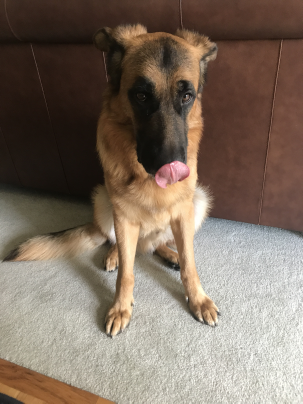

In [5]:
display_image_array(img)

# Method 1:  color quantization using kmeans clustering
This example was taken more or less exactly from this example in the scikit-learn documentation:

https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

In [6]:
n,m,d = img.shape # They labeled this "w,h,d", but they got width and height mixed up
n,m,d             # so I'm replacing it with the numpy convention

(4032, 3024, 3)

In [7]:
n_colors = 16

In [8]:
image_array = np.reshape(img, (n * m, d))

In [9]:
print("Fitting model on a small sub-sample of the data")
t0 = time()
img_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(img_sample)
print(f"done in {time() - t0:0.3f}s.")

Fitting model on a small sub-sample of the data
done in 0.762s.


In [10]:
# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")

Predicting color indices on the full image (k-means)
done in 0.409s.


In [11]:
codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")

Predicting color indices on the full image (random)
done in 0.444s.


In [12]:
def recreate_image(codebook, labels, n, m):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(n, m, -1)

new_img = recreate_image(kmeans.cluster_centers_, labels, n, m)

## Results:
I don't really like the results I got here, for a few reasons. 

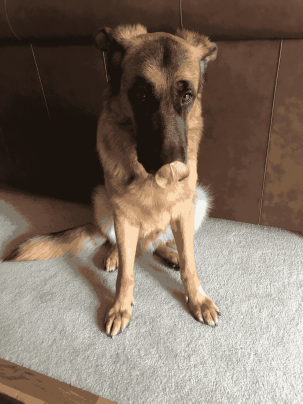

In [13]:
display_image_array(new_img)

As you can see, there's still a lot of fine structure that won't translate well to our ANSI art represenation. We've reduced the number of colors to 16, but all we've really done is make the image look duller. We've also lost some of the variance, the "pop" - the bright pink of the tongue has been made into a brown about the same color as the surrounding fur. 

I think the a big part of the problem is that we were operating at a global scale, but that's not where we're going to be operating. The total number of colors doesn't matter: what matters is that, once we divide the image into the rectangles that are going to be converted into ANSI formatted characters, each RECTANGLE must contain only two colors.

What we really want isn't to reduce the color pallete for the entire image, but to reduce the color pallete within the domain of a character sized rectangle.  

### Next steps:
- the final product will be reduced by a factor of 100
    - since the pixels are character of ANSI formatted text, we need a big reduction factor or it'll be huge
    - this will give us a shape 40 pixels high by 30 pixels wide
- there are two ways to do this: 
    - the fun way:
        - cut the array containing the image data into a bunch of 100x200 pixel slices (remember, characters are twice as high as they are wide)
        - then perform KMeans clustering with 2 centroids
        - assign each pixel a label
        - go through the available characters and calculate how well it fits (as foreground and background)
        - for each slice, assign a character        
    - the more pragmatic way:
        - use PIL, which is already very optimized and clever, to reduce the size of the image by a factor of 100
        - this will give us an image 40 pixels by 30 pixels
        - grab the color for the top and bottom
        - slice the unreduced array into 100x200 slices
        - using the two colors, calculate how well each character fits (as above)

In [14]:
def get_slices(img):
    """ Generator that yields 100x200 pixel slices of the
    given image array
    """
    n,m,d = img.shape
    rows = (n//100)//2
    columns = m//100
    for row in range(1, rows+1):
        for col in range(1, columns+1):
            yield img[100*(col-1):100*col,200*(row-1):200*row,:]

In [15]:
def fit_single_slice(array):
    n,m,d = array.shape
    image_array = np.reshape(array, (n * m, d))
    img_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(img_sample)

    labels = kmeans.predict(image_array)
    return kmeans.cluster_centers_[labels].reshape(n, m, -1)


In [16]:
n,m,d = img.shape
rows = (n//100)//2
columns = m//100
n, m, rows, columns

(4032, 3024, 20, 30)

In [17]:
# This can be written much faster, but I'm just getting and idea of the
# mechanics right now, so I might as well prioritize readability 
# Regardless; I expect this approach to be unacceptably slow even if I 
# were to optimize it more.
n,m,d = img.shape
rows = (n//100)//2
columns = m//100
out = []
start_time = time()
for row in tqdm(range(1, rows+1)):
    for col in range(1, columns+1):
        out.append(fit_single_slice(img[200*(row-1):200*row,100*(col-1):100*col,:]))
print(f"done in {time() - start_time:0.3f}s.")

  0%|          | 0/20 [00:00<?, ?it/s]

done in 15.010s.


In [18]:
# reassemble the entire array
new_img = np.vstack([np.hstack(out[30*(row-1):30*row]) for row in range(1, rows+1)])

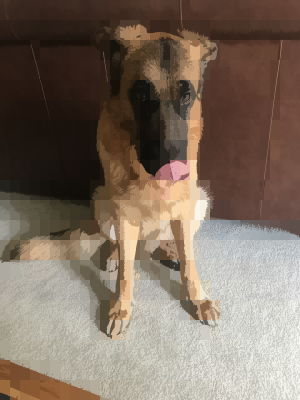

In [19]:
display_image_array(new_img, reduce_factor=10)

This is much better :) 

There's still room to improve, but we'll move on and see where this takes us

## Fitting the symbols to the image
I solved the problem of displaying an image in the terminal as ANSI formatted text already (see the blockification notebook), but I came back to the problem because I discovered the [Symbols for Legacy Computing unicode block](https://en.wikipedia.org/wiki/Symbols_for_Legacy_Computing). I think that I can use these characters (together with the vanilla block elements at U+2580-259F) to improve on the idea.

I'm sure there are other characters that could be useful, but this is good for at least a start. I want to keep things simple at this stage.

If these characters aren't available for you, it's because this unicode block isn't implemented by a lot of fonts yet. If install a font that does have them they should show up here. I recommend [the unscii font](https://github.com/viznut/unscii).

<img width="500" style="float: left;" src="images/Symbols_for_Legacy_Computing_Unicode_block.png">

### Line spacing
This is a minor cosmetic issue, but we can fix it with a little tinkering. 

Basically: the line-height attribute in this notebook is, by default, set to a little over the height of a character. This means that there's a little bit of white space between each row, even between unicode fullblocks:

## Note: this doesn't really work like I wanted it to
if you try to use this solution on the ANSI text image at the end, it doesn't work, lol

In [20]:
print('\n'.join(['\u2588'*80 for i in range(4)]))

████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████


We can fix this with a little bit of tinkering though:

In [21]:
from IPython.display import HTML

def smoosh_text(text):
    display(HTML(f'<p style="line-height: 1.0;">{text}</p>'))

In [22]:
smoosh_text('\n'.join(['\u2588'*80 for i in range(4)]))

In [23]:
def print_char_test():
    start_codepoint = ord('\U0001fb00')
    text = ''
    for i in range(6):
        start = i*16
        stop = start + 80
        text += ''.join([chr(start_codepoint+i) for i in range(start,stop)])
        text += '\n'
    smoosh_text(text)

print_char_test()

In [24]:
block_elements = [chr(i) for i in range(9600, 9631+1)]
legacy_computing = [chr(i) for i in range(129792, 129951+1)]
# let's remove this extra, unimplemented codepoint they stuck in the middle 🙄
legacy_computing.remove('\U0001fb93')
character_set = block_elements + legacy_computing

### OK, we have a set of characters. Now what?

Now we need to turn the characters into arrays. I fiddled around with the idea and came up with a solution. It's probably not the best approach, but it works. 

In [25]:
from PIL import Image, ImageDraw, ImageFont

def character_bitmap(
        char: str,
        font_path: str,
        font_size: int):
    """ Input:
            char: str - the character for which we want a bitmap
            font_path: str - the path to the font file for which we want to
                generate a bitmap
            font_size: int - the height of the character
    """
    font = ImageFont.truetype(font_path, font_size)
    font_len = int(font.getlength(char))
    font_height = int(font_size)
    out = Image.new("L", (font_len, font_height))
    d = ImageDraw.Draw(out)
    d.text((0, 0), char, font=font, fill=255)
    # If we just take np.asarray(out) we get an array of values between
    # 0 and 255 (there are some intermediate values on the edges).
    # I don't know how to tell PIL that I only want 1s or 0s, so I'm
    # just dividing by 255 and rounding. 
    # This probably isn't a GREAT assumption, but ¯\_(ツ)_/¯
    return np.asarray(out)

def transformed_bitmap(arr):
    w,h = arr.shape
    return np.round(np.asarray(arr)/255).astype(np.uint8).reshape((w*h,))

def get_character_bitmap(
        char: str,
        font_path: str,
        font_size: int):
    return transformed_bitmap(character_bitmap(char,font_path,font_size))

In [26]:
character_bitmap('A', 'fonts/unscii-16.ttf', 20)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  32, 128, 128,  32,   0,   0,   0],
       [  0,   0,  32, 112, 255, 255, 112,  32,   0,   0],
       [  0,   0, 128, 255, 255, 255, 255, 128,   0,   0],
       [  0, 192, 255, 192,   0,   0, 192, 255, 192,   0],
       [  0, 192, 255, 192,   0,   0, 192, 255, 192,   0],
       [  0, 192, 255, 192,   0,   0, 192, 255, 192,   0],
       [  0, 192, 255, 208,  64,  64, 208, 255, 192,   0],
       [  0, 192, 255, 255, 255, 255, 255, 255, 192,   0],
       [  0, 192, 255, 192,   0,   0, 192, 255, 192,   0],
       [  0, 192, 255, 192,   0,   0, 192, 255, 192,   0],
       [  0, 192, 255, 192,   0,   0, 192, 255, 192,   0],
       [  0, 192, 255, 192,   0,   0, 192, 255, 192,   0],
       [  0, 192, 255, 192,   0,   0, 192, 255, 192,   0],
       [  0, 192, 255, 192,   0,   0, 192, 255, 192,   0],
       [  0,  48,  64,  48,   0,   0,  48,  64,  48,   0

In [27]:
character_bitmap('\u2588', 'fonts/unscii-16.ttf', 10)

array([[255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255]], dtype=uint8)

In [28]:
mapping_dict = {c:get_character_bitmap(c, 'fonts/unscii-16.ttf', 200) for c in character_set}

In [29]:
mapping_dict

{'▀': array([1, 1, 1, ..., 0, 0, 0], dtype=uint8),
 '▁': array([0, 0, 0, ..., 1, 1, 1], dtype=uint8),
 '▂': array([0, 0, 0, ..., 1, 1, 1], dtype=uint8),
 '▃': array([0, 0, 0, ..., 1, 1, 1], dtype=uint8),
 '▄': array([0, 0, 0, ..., 1, 1, 1], dtype=uint8),
 '▅': array([0, 0, 0, ..., 1, 1, 1], dtype=uint8),
 '▆': array([0, 0, 0, ..., 1, 1, 1], dtype=uint8),
 '▇': array([0, 0, 0, ..., 1, 1, 1], dtype=uint8),
 '█': array([1, 1, 1, ..., 1, 1, 1], dtype=uint8),
 '▉': array([1, 1, 1, ..., 0, 0, 0], dtype=uint8),
 '▊': array([1, 1, 1, ..., 0, 0, 0], dtype=uint8),
 '▋': array([1, 1, 1, ..., 0, 0, 0], dtype=uint8),
 '▌': array([1, 1, 1, ..., 0, 0, 0], dtype=uint8),
 '▍': array([1, 1, 1, ..., 0, 0, 0], dtype=uint8),
 '▎': array([1, 1, 1, ..., 0, 0, 0], dtype=uint8),
 '▏': array([1, 1, 1, ..., 0, 0, 0], dtype=uint8),
 '▐': array([0, 0, 0, ..., 1, 1, 1], dtype=uint8),
 '░': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 '▒': array([1, 1, 1, ..., 1, 1, 1], dtype=uint8),
 '▓': array([1, 1, 1, ..., 1, 1

In [30]:
def fit_single_slice2(array):
    n,m,d = array.shape
    image_array = np.reshape(array, (n * m, d))
    img_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(img_sample)

    labels = kmeans.predict(image_array)
    return kmeans.cluster_centers_[labels].reshape(n, m, -1), kmeans, labels

In [31]:
image_slice = img[1800:2000,1400:1500]
arr, kmeans, labels = fit_single_slice2(image_slice)

In [32]:
x = mapping_dict['▀']

In [33]:
jaccard(labels, x)

0.8131924235462297

In [34]:
jaccard(labels, 1-x)

0.29811845669521925

In [35]:
kmeans.cluster_centers_

array([[0.56548775, 0.39804532, 0.26531061],
       [0.75627942, 0.58911895, 0.43176528]])

In [36]:
(kmeans.cluster_centers_*255).astype(np.uint8)

array([[144, 101,  67],
       [192, 150, 110]], dtype=uint8)

In [37]:
display_image_array(image_slice)

In [49]:
def character_match(array):
    arr, kmeans, labels = fit_single_slice2(array)
    best_fit = 0
    best_char = ''
    out_dict = dict()
    for character, bitmap in mapping_dict.items():
        for is_inverted in [True, False]:
            if is_inverted:
                this_fit = jaccard(labels, 1 - bitmap)
            else:
                this_fit = jaccard(labels, bitmap)
            if this_fit > best_fit:
                colors = (kmeans.cluster_centers_*255).astype(np.uint8)
                if is_inverted == 0:
                    foreground = colors[0]
                    background = colors[1]
                else:
                    foreground = colors[1]
                    background = colors[0]
                best_fit = this_fit
                best_char = character
                out_dict = {
                    'fit':best_fit,
                    'character':best_char,
                    'foreground':foreground,
                    'background':background,
                }
    return out_dict

In [39]:
# array = character_bitmap('🬤', 'fonts/unscii-16.ttf', 200)
# array = np.asarray(array)//255

In [40]:
# arr, kmeans, labels = kmeans.cluster_centers_[labels].reshape(200, 100), kmeans, labels
# best_fit = 0
# best_char = ''
# out_dict = dict()
# for character, bitmap in mapping_dict.items():
#     for is_inverted in [True, False]:
#         if is_inverted:
#             this_fit = jaccard(labels, 1 - bitmap)
#         else:
#             this_fit = jaccard(labels, bitmap)
#         if this_fit > best_fit:
#             colors = (kmeans.cluster_centers_*255).astype(np.uint8)
#             if is_inverted == 0:
#                 foreground = colors[1]
#                 background = colors[0]
#             else:
#                 foreground = colors[0]
#                 background = colors[1]
#             best_fit = this_fit
#             best_char = character
#             out_dict = {
#                 'fit':best_fit,
#                 'character':best_char,
#                 'foreground':foreground,
#                 'background':background,
#             }

In [41]:
def format_rgb(char: str, 
               foreground: tuple, 
               background: tuple):
    rf,gf,bf = foreground
    rb,gb,bb = background
    formatted_string = '\033['
    formatted_string += f'38;2;{rf};{gf};{bf};'
    if rb or gb or bb:
        formatted_string += f'48;2;{rb};{gb};{bb};'
    formatted_string = formatted_string[:-1]
    formatted_string += f'm{char}\033[0m'
    return formatted_string

In [42]:
print(format_rgb('Stuff', (0,200,250), (0,100,0)))

Stuff


In [50]:
n,m,d = img.shape
rows = (n//100)//2
columns = m//100
out = ''
start_time = time()
for row in tqdm(range(1, rows+1)):
    for col in range(1, columns+1):
        best_char = character_match(img[200*(row-1):200*row,100*(col-1):100*col,:])
        out += format_rgb(
                best_char['character'], 
                best_char['foreground'],
                best_char['background'])
    out += '\n'
# # reassemble the entire array
# new_img = np.hstack([np.vstack(out[30*(row-1):30*row]) for row in range(1, rows+1)])
# print(f"done in {time() - start_time:0.3f}s.")

  0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
print(out)

██████████████████████████████
███████████▆▆▇▇▀▀▅█▅▀█████████
███▇██████▀███████████████████
██████████████████████████████
██████████▀███████████████████
██████████████▁███████████████
██████████████████████████▅▁██
█████████████▇████████████████
██████████████▇▅██████████████
▅▀▀██████▇█████████▀▇▆████████
████████▇█████████████▀███▁███
███▇▀▇█▅▅█████████████████▆▆▅▀
██████▇█████████▇█████████████
██████████████▆█▇█████████████
████████████████▇█████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██▇▆█▅████████████████████████
▀▆▇▅██▀▇▆█████████████████████



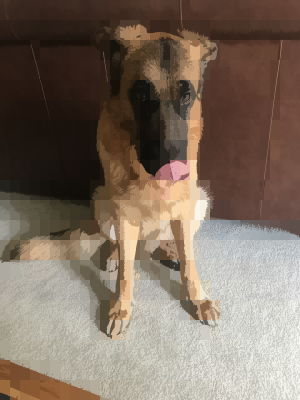

In [52]:
display_image_array(new_img, reduce_factor=10)

In [277]:
array = character_bitmap('A', 'fonts/unscii-16.ttf', 200)
array = np.asarray(array)/255


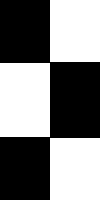

In [87]:
make_255 = lambda img_arr: (img_arr*255).astype(np.uint8) # converts back to int 0-255
Image.fromarray(make_255(array))

In [123]:
last = 0
this_count = 0
counts = []
for i in array[:,0]:
    if i != last:
        counts.append(this_count)
        last = i
        this_count = 0
    this_count += 1
counts.append(this_count)

In [124]:
counts

[63, 74, 63]

In [279]:
array.shape

(200, 100)

In [84]:
image_array = np.reshape(array, (20000, 1))
img_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=2, random_state=0).fit(img_sample)

labels = kmeans.predict(image_array)


In [85]:
new_img = kmeans.cluster_centers_[labels].reshape(200, 100)

In [86]:
Image.fromarray(make_255(new_img))

NameError: name 'make_255' is not defined

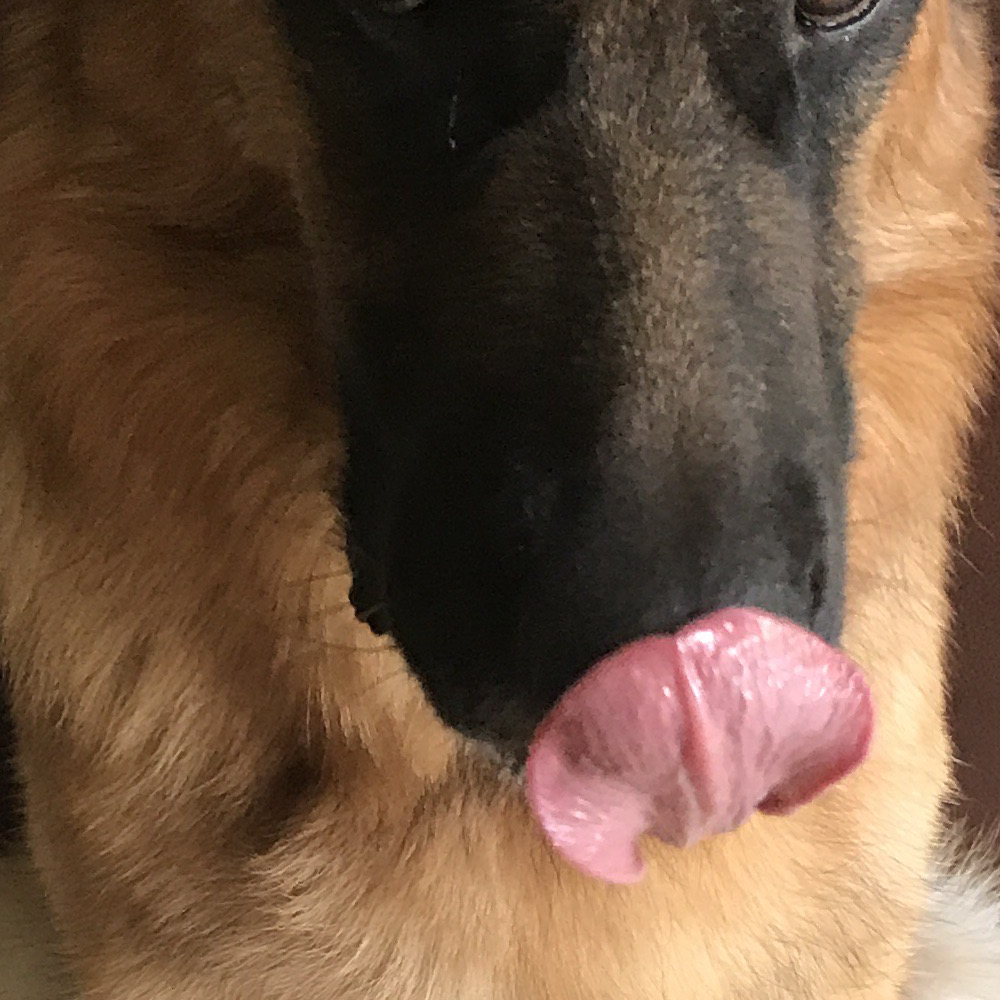

In [292]:
Image.fromarray(make_255(np.rot90(img[1000:2000,1000:2000], axes=(1,0))))